<h1> Neural Network from Scratch </h1>

In this project, we implement a simple feedforward neural network using only NumPy. The goal is to understand how deep learning models work internally including `forward propagation, activation functions, backpropagation and gradient descent` without relying on high level frameworks like TensorFlow or PyTorch.

We train the model on a multi-class classification problem and evaluate its performance using accuracy. 

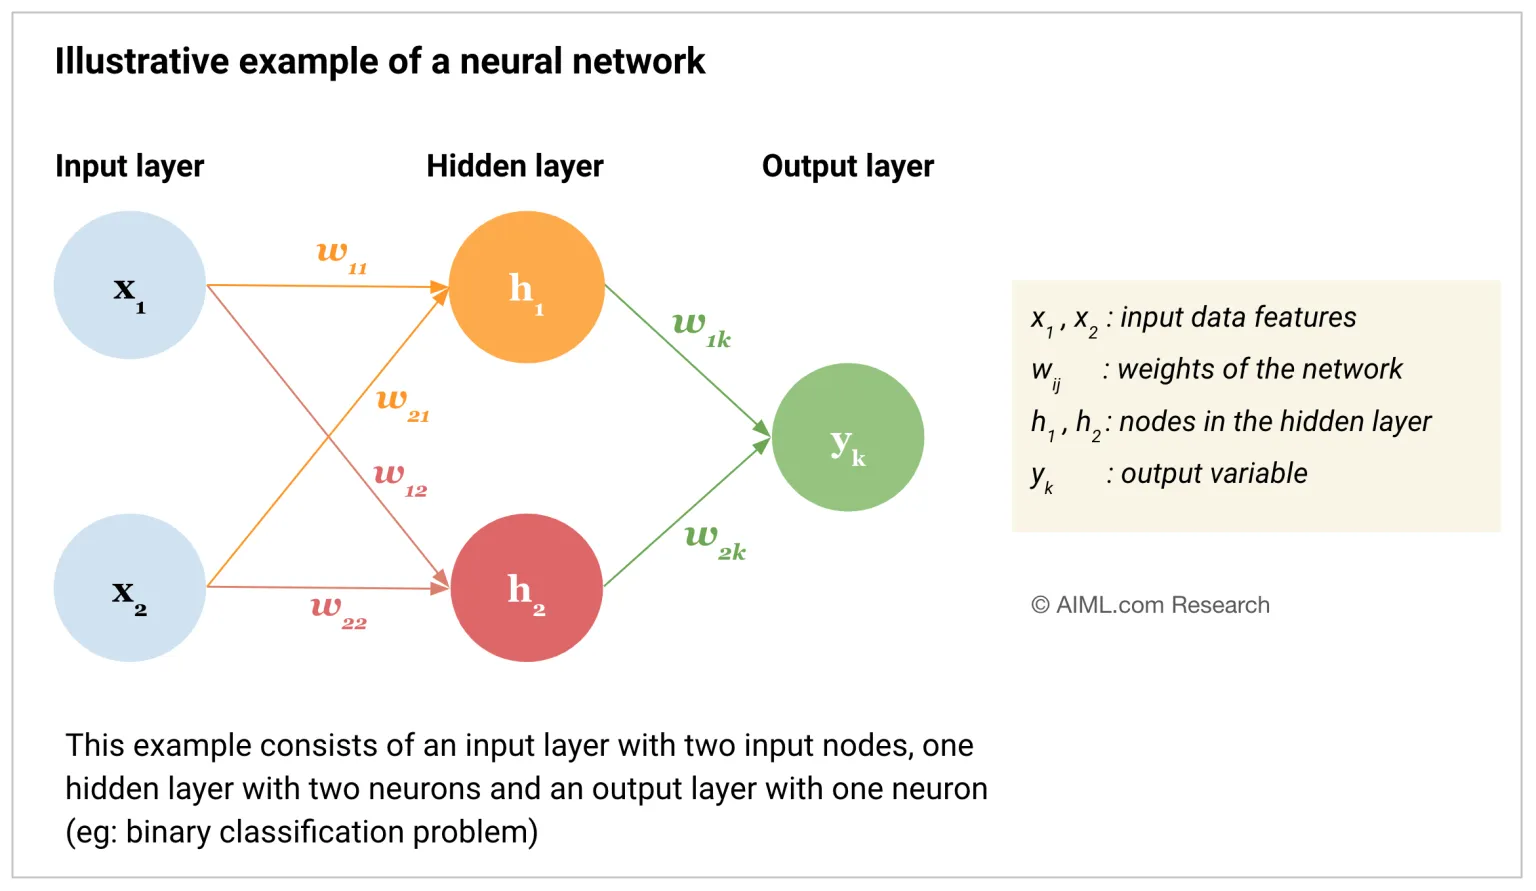
diagram from : https://aiml.com/what-is-the-basic-architecture-of-an-artificial-neural-network-ann/
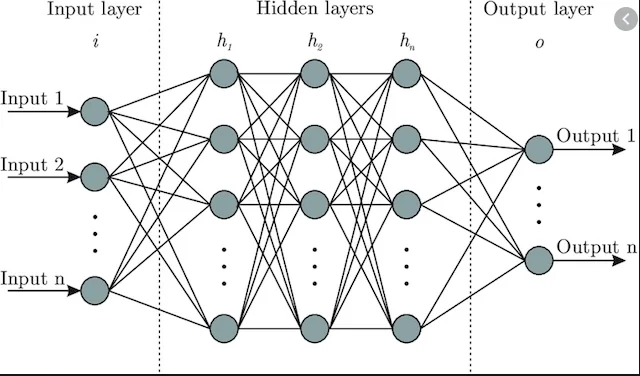
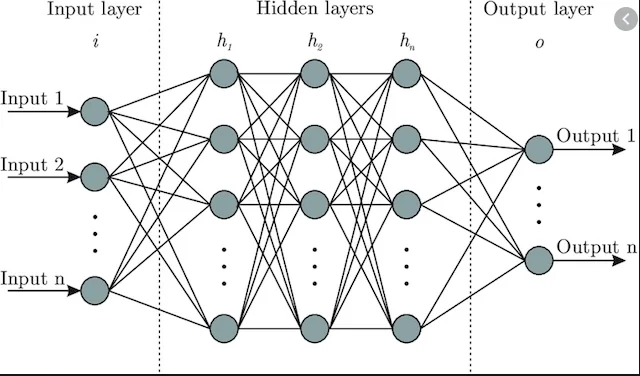
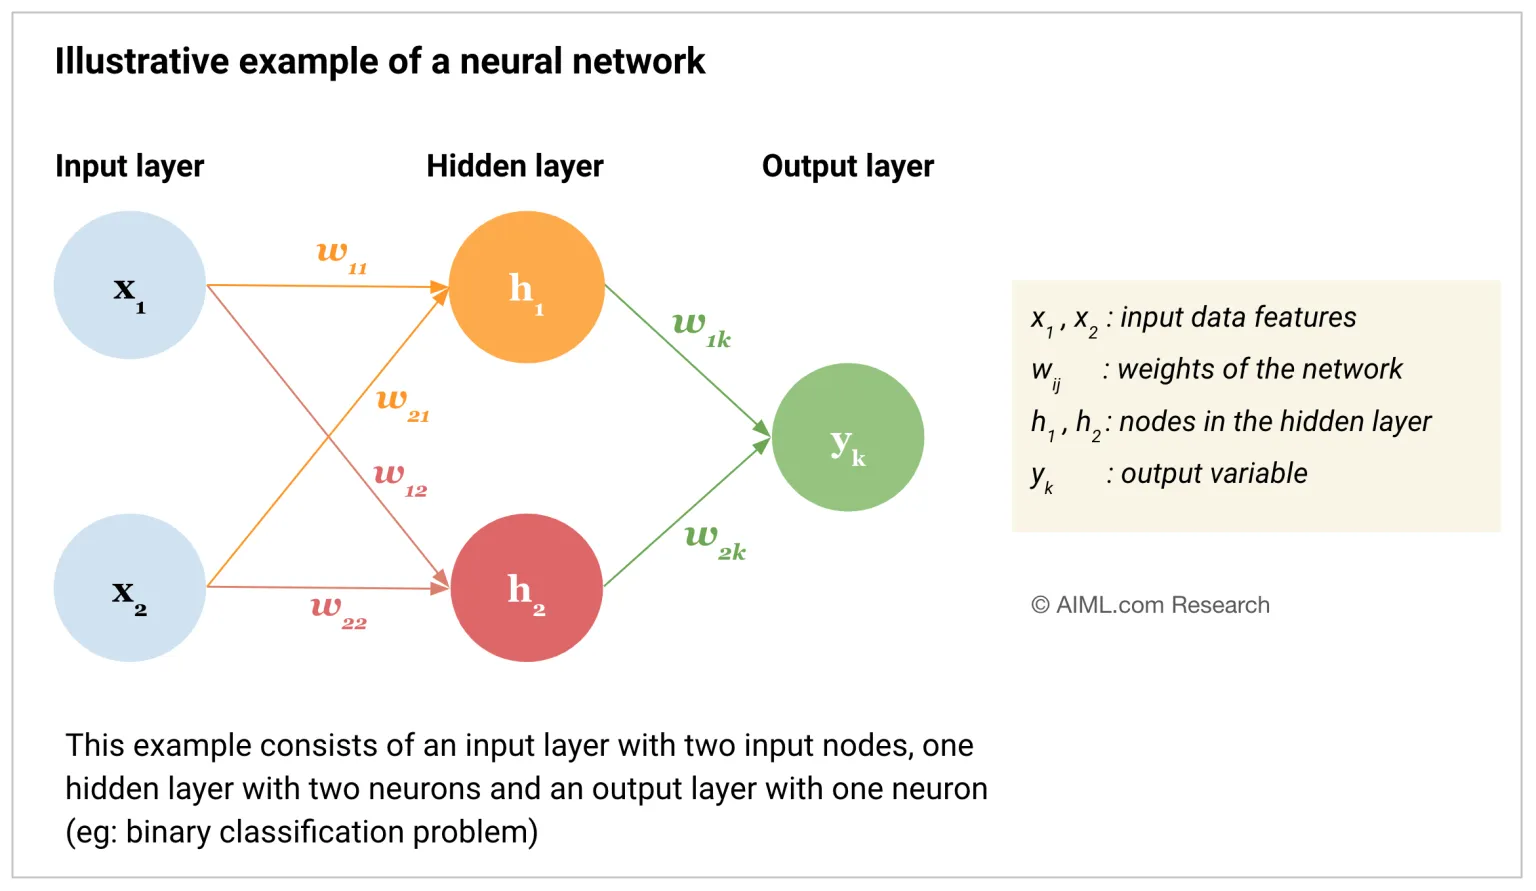

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

2025-07-03 14:05:27.255001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751551527.505852      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751551527.577277      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Initializing Weights and Biases (Xavier Initialization)

We use Xavier Initialization to keep the variance of activations stable across layers.

For each layer $l$:
- $W^{[l]} \sim \mathcal{N}(0, \frac{1}{n^{[l-1]}})$
- $b^{[l]} \sim \mathcal{N}(0, 1)$

Where $n^{[l-1]}$ is the number of units in the previous layer

This prevents gradients from vanishing or exploding in deep networks.

In [2]:
def initialize_parameters(layers_dim):
    np.random.seed(42)
    params = {}
    for i in range(1, len(layers_dim)):
        params['W' + str(i)] = np.random.randn(layers_dim[i], layers_dim[i - 1]) * np.sqrt(1. / layers_dim[i - 1])
        params['b' + str(i)] = np.random.randn(layers_dim[i], 1)
    return params

## Activation Functions

We use two main activation functions:

- **ReLU** (Rectified Linear Unit):  
  $$
  \text{ReLU}(z) = \max(0, z)
  $$

  Derivative:
  $$
  \text{ReLU}'(z) = 
  \begin{cases}
  1 & \text{if } z > 0 \\
  0 & \text{otherwise}
  \end{cases}
  $$

- **Softmax**: used in the final layer to produce probabilities:
  $$
  \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_j e^{z_j}}  $$


In [3]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

## Forward Propagation

We compute the output of each layer using:

$$
Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}
$$

$$
A^{[l]} = \text{activation}(Z^{[l]})
$$

Where:
- $A^{[0]} = X$ (input features)
- ReLU is used in hidden layers, Softmax in the output


In [4]:
def propagate_forward(X, layers_dim, params):
    cache = {'A0': X}
    A = X

    for i in range(1, len(layers_dim)):
        W = params['W' + str(i)]
        b = params['b' + str(i)]
        Z = np.dot(W, A) + b

        if i < len(layers_dim) - 1:
            A = relu(Z)
        else:
            A = softmax(Z)

        cache['Z' + str(i)] = Z
        cache['A' + str(i)] = A

    return A, cache

## Loss Function (Categorical Cross-Entropy)

For multi-class classification, we use **cross-entropy loss**:

$$
\mathcal{L} = -\frac{1}{m} \sum_{i=1}^{m} \sum_{j=1}^{C} y_j^{(i)} \log(\hat{y}_j^{(i)})
$$

Where:
- $m$ = number of examples  
- $C$ = number of classes  
- $y$ = true label (one-hot encoded)  
- $\hat{y}$ = predicted probability from Softmax


In [5]:
def compute_loss(AL, Y):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(AL + 1e-8)) / m
    return loss

## Backpropagation

Backpropagation uses the chain rule to compute gradients and update weights:

$$
\delta^{[l]} = (W^{[l+1]})^T \delta^{[l+1]} \odot g'^{[l]}(Z^{[l]})
$$

Weight gradients:

$$
\frac{\partial \mathcal{L}}{\partial W^{[l]}} = \delta^{[l]} (A^{[l-1]})^T
$$

Bias gradients:

$$
\frac{\partial \mathcal{L}}{\partial b^{[l]}} = \delta^{[l]}
$$

Weight update using gradient descent:

$$
W^{[l]} := W^{[l]} - \alpha \cdot \frac{\partial \mathcal{L}}{\partial W^{[l]}}
$$


In [6]:
def backprop(cache, params, Y, layers_dim, learning_rate=0.01):
    m = Y.shape[1]
    L = len(layers_dim) - 1

    dZ = cache['A' + str(L)] - Y 

    for l in reversed(range(1, L + 1)):
        A_prev = cache['A' + str(l - 1)]
        Z = cache['Z' + str(l)]
        W = params['W' + str(l)]

        if l < L:
            dZ = dZ * relu_derivative(Z)

        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m

        params['W' + str(l)] -= learning_rate * dW
        params['b' + str(l)] -= learning_rate * db

        if l > 1:
            dZ = np.dot(W.T, dZ)

## Making Predictions

Predictions are made by selecting the class with the highest Softmax output:

$$
\hat{y} = \arg\max(\text{Softmax}(Z^{[L]}))
$$


In [7]:
def get_predictions(AL):
    return np.argmax(AL, axis=0)

def get_accuracy(predictions, Y):
    labels = np.argmax(Y, axis=0)
    return np.mean(predictions == labels)

## Training the Neural Network

The training loop includes:
- Forward propagation
- Loss computation
- Backpropagation
- Accuracy logging 

In [23]:
# Training Function
def train(X, Y, layers_dim, iterations=1000, learning_rate=0.01):
    params = initialize_parameters(layers_dim)

    for i in range(iterations):
        AL, cache = propagate_forward(X, layers_dim, params)
        loss = compute_loss(AL, Y)
        backprop(cache, params, Y, layers_dim, learning_rate)

        
        if i % 100 == 0:
            predictions = get_predictions(AL)
            acc = get_accuracy(predictions, Y)
            print(f"Iteration {i}: Loss = {loss:.4f} | Accuracy = {acc:.4f}")

    return params

In [9]:
def predict(X, params, layers_dim):
    AL, _ = propagate_forward(X, layers_dim, params)
    return np.argmax(AL, axis=0)  # Class predictions (0–9)

## Data Loading and Preprocessing (MNIST)

We load the MNIST dataset. It contains 70,000 grayscale images of handwritten digits (0–9) each of size 28×28 pixels.

### Steps:
1. **Load the data** using `keras.datasets.mnist`.
2. **Normalize pixel values** to the range [0, 1] by dividing by 255 (max pixel value)
4. **Flatten the images**: reshape from (28, 28) to a vector of size 784 and transpose the dataset to shape (features, samples).
5. **One-hot encode the labels**: Converts scalar labels like `3` into vectors like `[0, 0, 0, 1, 0, ..., 0]`.

In [10]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(-1, 784).T  # Shape: (784, num_samples)
X_test = X_test.reshape(-1, 784).T

y_train_oh = np.eye(10)[y_train].T  # Shape: (10, num_samples)
y_test_oh = np.eye(10)[y_test].T

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [24]:
layers_dim = [784,64,32,10]
trained_params = train(X_train, y_train_oh, layers_dim, iterations=800, learning_rate=0.1)

Iteration 0: Loss = 3.1170 | Accuracy = 0.0993
Iteration 100: Loss = 0.5321 | Accuracy = 0.8602
Iteration 200: Loss = 0.3786 | Accuracy = 0.8938
Iteration 300: Loss = 0.3333 | Accuracy = 0.9042
Iteration 400: Loss = 0.3089 | Accuracy = 0.9111
Iteration 500: Loss = 0.2916 | Accuracy = 0.9157
Iteration 600: Loss = 0.2776 | Accuracy = 0.9198
Iteration 700: Loss = 0.2649 | Accuracy = 0.9235


In [25]:
y_pred = predict(X_test, trained_params, layers_dim)
y_true = np.argmax(y_test_oh, axis=0)

accuracy = np.mean(y_pred == y_true) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.88%


In [26]:
trained_params

{'W1': array([[ 0.01773979, -0.00493801,  0.02313173, ..., -0.04769087,
          0.01357849,  0.02180663],
        [ 0.01999252,  0.03859931,  0.02978293, ..., -0.01004741,
          0.00239253,  0.0184264 ],
        [-0.05580521, -0.01889474,  0.0283666 , ..., -0.01400045,
          0.03785487,  0.02203593],
        ...,
        [ 0.03201384,  0.02675996, -0.01336246, ...,  0.02256244,
         -0.02670094,  0.04678863],
        [-0.02087065,  0.03962292,  0.08090054, ...,  0.02943682,
          0.00890256, -0.00427599],
        [ 0.00222667,  0.00266519,  0.04197013, ..., -0.02032842,
          0.05708488, -0.0234534 ]]),
 'b1': array([[ 0.9625342 ],
        [ 0.07774612],
        [ 0.7770016 ],
        [-0.81778456],
        [-0.27118468],
        [-0.02313028],
        [-0.63129848],
        [ 1.24673499],
        [-0.76428007],
        [-0.56941276],
        [ 1.40858072],
        [ 1.15885431],
        [ 1.58367162],
        [-1.90827316],
        [ 0.25169692],
        [ 0.1272